## Preparation

### Libraries

In [1]:
try:
    import secmlt

except ImportError:
    print("Installing the dependancies")
    %pip install git+https://github.com/pralab/secml-torch

import torch
import numpy as np
import random
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from secmlt.metrics.classification import Accuracy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import torch

from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

seed = 999
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

### Points generation

We create some data using another library called `scikit-learn`.

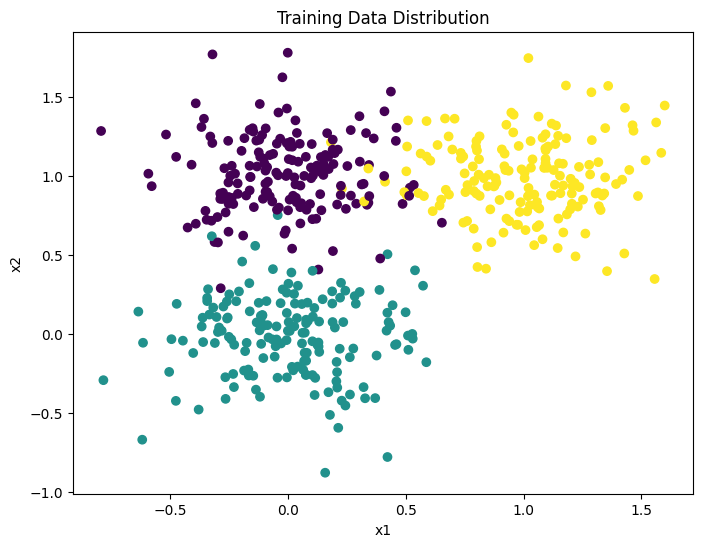

Data shape: torch.Size([500, 2])
Labels shape: torch.Size([500])


In [2]:
def plot_data(X, y, title="Data Distribution"):
    """
    Plot the data points colored by their classes.
    
    Args:
        X: Input features as tensor or numpy array
        y: Labels as tensor or numpy array
        title: Plot title
    """
    # Convert tensors to numpy if needed
    if torch.is_tensor(X):
        X = X.detach().numpy()
    if torch.is_tensor(y):
        y = y.detach().numpy()
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

centers = [(0, 1), (0, 0), (1, 1)]
cluster_std = 0.25

X_train, y_train = make_blobs(n_samples=500, 
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=seed)

# Visualize the data
plot_data(X_train, y_train, title="Training Data Distribution")

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

print(f"Data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")

We do the same to create test data, that will be used to compute the accuracy of our model.

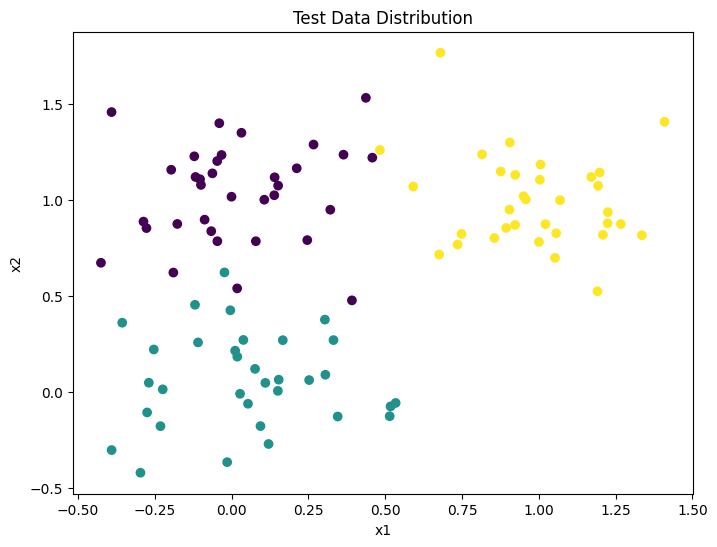

Data shape: torch.Size([100, 2])
Labels shape: torch.Size([100])


In [3]:
X_test, y_test = make_blobs(n_samples=100, 
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=seed)

plot_data(X_test, y_test, title="Test Data Distribution")

# Convert to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"Data shape: {X_test.shape}")
print(f"Labels shape: {y_test.shape}")

We also already converted those samples in torch Tensors, which are the basic and main Pytorch objects.
Observations are defined as FloatTensors, while labels are LongTensors.

We can now create a main concept in Pytorch, which is the DataLoader.
A DataLoader dispatches data in batches, ready to be used to train models.

In [4]:
tr_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=5, shuffle=False)

print(f"Number of batches: {len(tr_dataloader)}")

Number of batches: 16


### Neural Network
<i>Provided adversarial training with FGSM, train a model with and without the defense.</i>
<br><br>
To train we need:

* a Loss Function, which quantifies the errors of the model
* an Optimization Algorithm, to fine-tune the parameters of the model

Hence, through gradient-descent it's possible to iteratively find the optimal parameters.

Training is achieved in epochs, which stands for the amount of time the whole dataset is fed to the optimization algorithm to train the weights.

#### Normally trained

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 32)  
        self.fc2 = torch.nn.Linear(32, 16)
        self.fc3 = torch.nn.Linear(16, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
epochs = 1000
lr = 1e-3

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=epochs)
secmlt_model = BasePytorchClassifier(model, trainer=trainer)
secmlt_model.train(tr_dataloader)
accuracy1 = Accuracy()(secmlt_model, ts_dataloader)

print(model)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Test accuracy model 1: {:.2f}%".format(accuracy1 * 100))

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)
Number of parameters: 675
Test accuracy model 1: 97.00%


Plotting

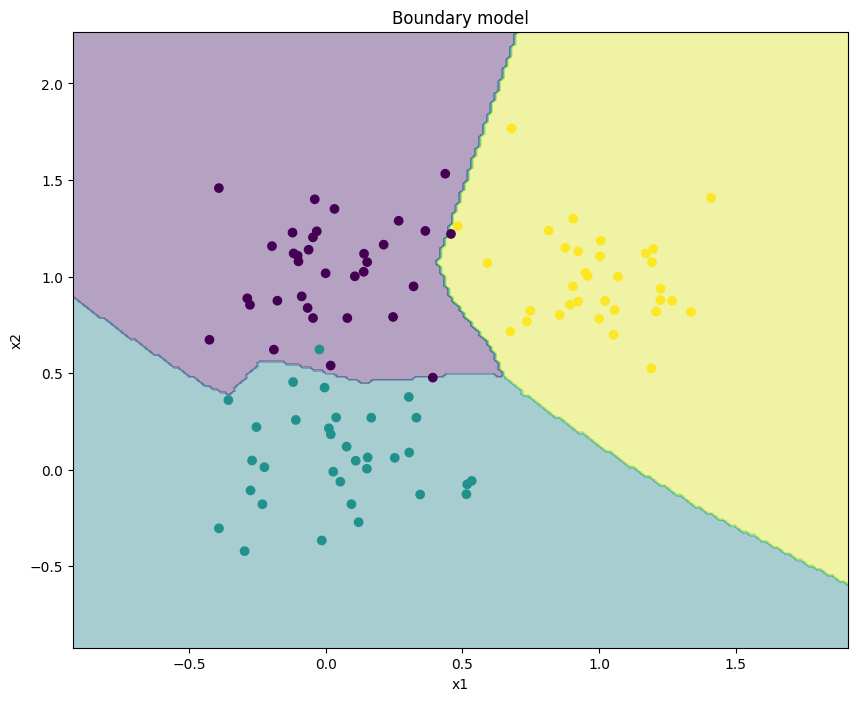

In [6]:
def plot_decision_regions(model, X, y, title="Decision Regions"):
    """
    Plot decision regions for a PyTorch model.
    
    Args:
        model: PyTorch model (must be in eval mode)
        X: Input features as tensor
        y: Labels as tensor
        title: Plot title
    """
    # Convert tensors to numpy for plotting
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    
    # Create a mesh grid
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    
    # Get predictions for each point in the mesh
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)
    
    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    
    # Plot data points
    scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, 
                         cmap='viridis')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

plot_decision_regions(model, X_test, y_test, "Boundary model")

#### Adversarially trained
Given this network, we need to tweak the training loop that we saw at the beginning of the course.
Since we have a deep neural network, we **can not** compute adversarial training in closed form.

Hence, the only way is *approximating* the technique by iteratively create adversarial examples while optimizing.
This can be done in multiple ways:

* at each iteration, we create adversarial examples and include them in training (very time consuming)
* train the model for some epochs, compute adversarial attacks, include them in the training, repeat
* fine-tune the trained model with one attack with larger epsilon (less granular, but fast)

Here we are going to use a very easy approach, through Fast Gradient Sign Method (FGSM), which is a single-step attack with a large L-infinity norm.

Epoch 100, Loss: 0.6519
Epoch 200, Loss: 0.6529
Epoch 300, Loss: 0.6496
Epoch 400, Loss: 0.6362
Epoch 500, Loss: 0.6154
Epoch 600, Loss: 0.5963
Epoch 700, Loss: 0.5618
Epoch 800, Loss: 0.5271
Epoch 900, Loss: 0.5228
Epoch 1000, Loss: 0.5246


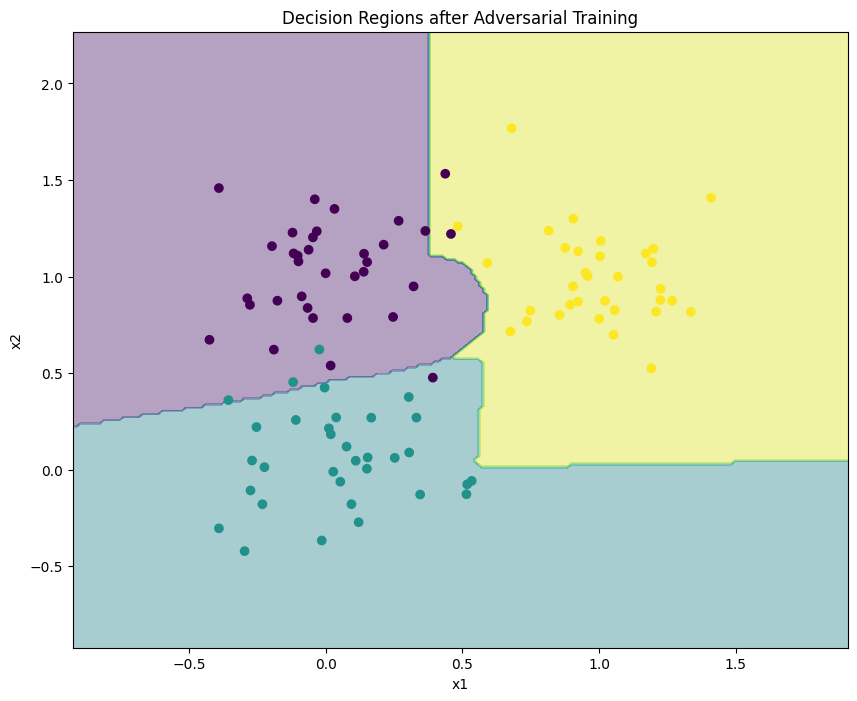

In [7]:
model = Net()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

epsilon = 0.3

for epoch in range(epochs):
    running_loss = 0.0

    for inputs, labels in tr_dataloader:
        # Compute adversarial samples with 1-iteration attack
        model.eval()
        x = inputs.clone().detach().requires_grad_(True)
        outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = x.grad.data
        inputs_adv = x.data + epsilon * torch.sign(gradient)

        # Compute loss and backpropagate as usual
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs_adv)
        loss = criterion(outputs, labels)
        loss.backward()                 
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(tr_dataloader.dataset)
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

at_model = BasePytorchClassifier(model)
plot_decision_regions(model, X_test, y_test, title="Decision Regions after Adversarial Training")

## Security Evaluation
<i>Compute and plot security evaluations of both.</i>
<br><br>
The computation of security evaluations involve repeating attacks with increasing strength, hence it shuld approximate all the possible scenarios that can be envisioned once the models are deployed.

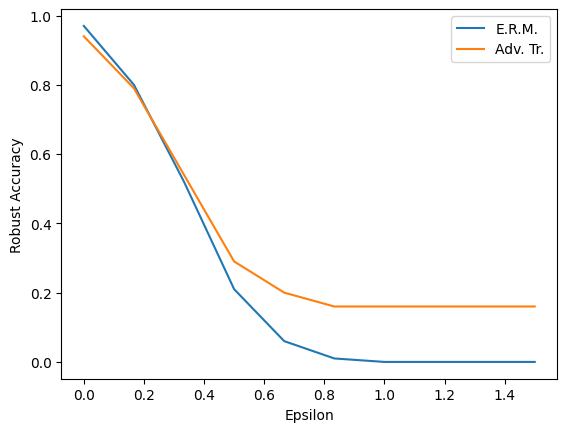

In [8]:
def security_evaluation_pgd_linf(model, testloader, epsilons, iterations=100, stepsize=0.01):
    sec_eval_data = []

    for e in epsilons:
        attack = PGD(
            perturbation_model=LpPerturbationModels.LINF,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None,
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
        
        adv_dataloader = attack(model, testloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
        
    return sec_eval_data

epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500

#First model: trained normally
security_eval_no_at = security_evaluation_pgd_linf(secmlt_model, ts_dataloader, epsilons=epsilons, iterations=iterations, stepsize=0.1)

#Second model: trained with adversarial training
security_eval_at = security_evaluation_pgd_linf(at_model, ts_dataloader, epsilons=epsilons, iterations=iterations, stepsize=0.1)

plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.legend()
plt.show()

### Results

For small perturbations, the models behave similarly: the decision boundaries are not yet significantly stressed by the attack.<br>
For moderate perturbations, the gap starts to increase: ERM accuracy collapes rapidly, while AdvTr degrades more smoothly as training flattened and regularized the loss landscape.<br>
For large perturbations, we achieve a situation where we always have a subset of samples that remain correctly classified.<br>
So,
* ERM: high clean accuracy, not suitable for adversarial testing
* AdvTr: worse clean accuracy, higher robustness